In [2]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table

from ResidualUtils import getwavs#, getspecpath



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif',
                            'pgf.texsystem': 'pdflatex'})
# plt.rcParams['pgf.texsystem'] = 'pdflatex'



flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
rainbow = tol_cmap('rainbow_PuRd')
sunset = tol_cmap('sunset')
iridescent = tol_cmap('iridescent')
for map in [rainbow, sunset, iridescent]:
    map.set_bad('white',1.)

In [3]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]
CA_clean = CA_stars[np.invert(np.logical_or.reduce([np.isnan(CA_stars['TEFF']), np.isnan(CA_stars['LOGG']), 
                                           np.isnan(CA_stars['M_H'])]))]

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0]

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [4]:
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)

In [5]:
def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce([teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
        print('Wrong number of rows')
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j_ind'], row['k_ind'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu

def get_residuals_from_tab(tab):
    residuals = []
    for row in tab:
        hdu = get_residual(row['TEFF'], row['LOGG'], row['M_H'])
        residuals.append(hdu)
    return residuals

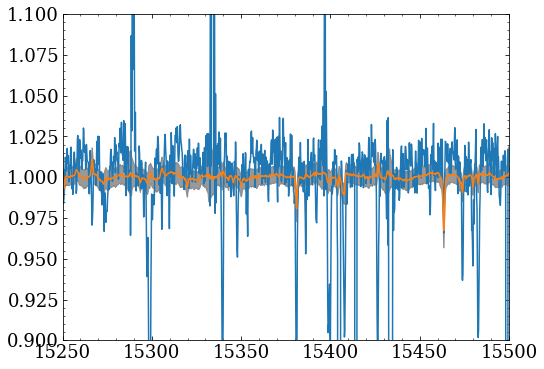

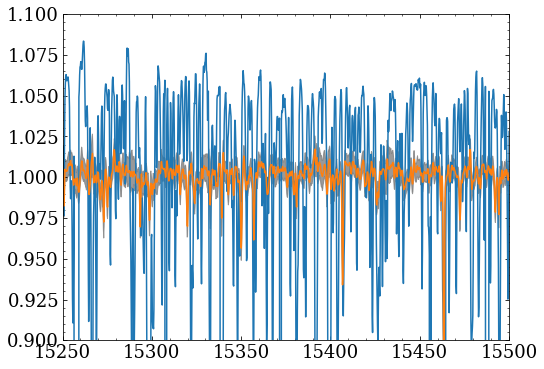

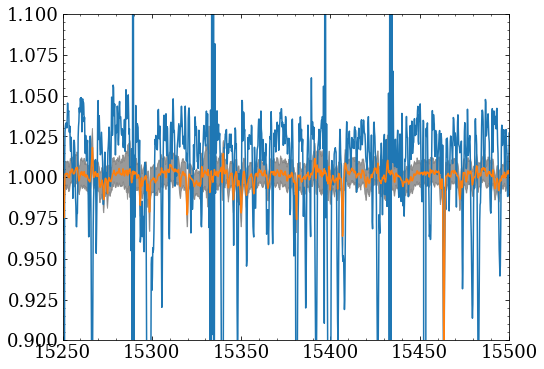

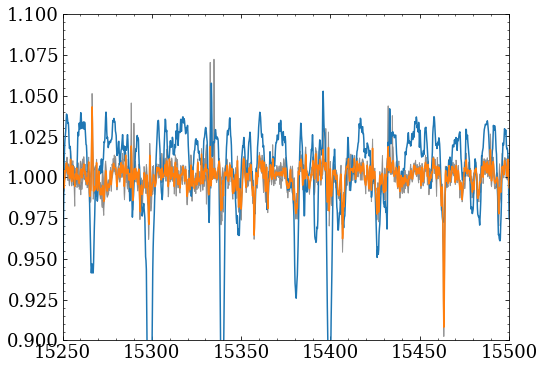

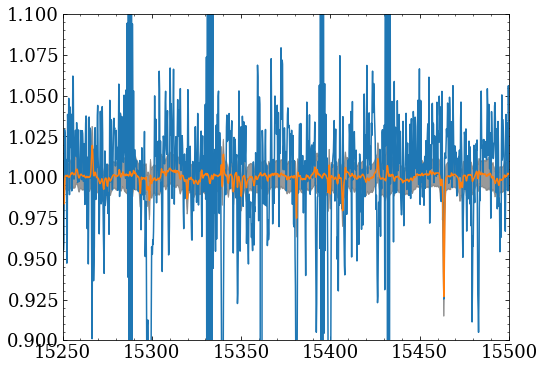

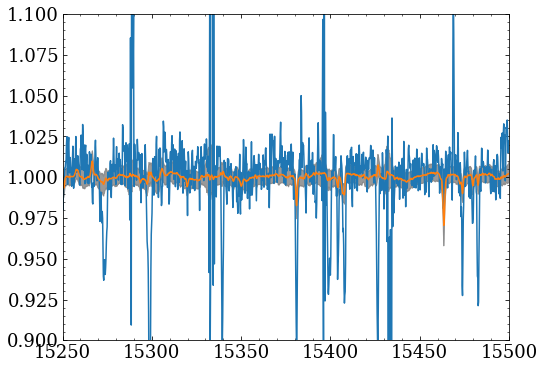

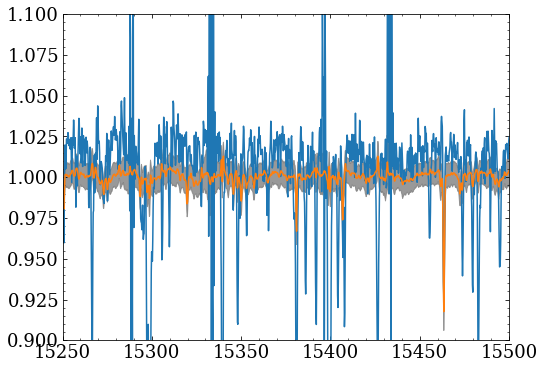

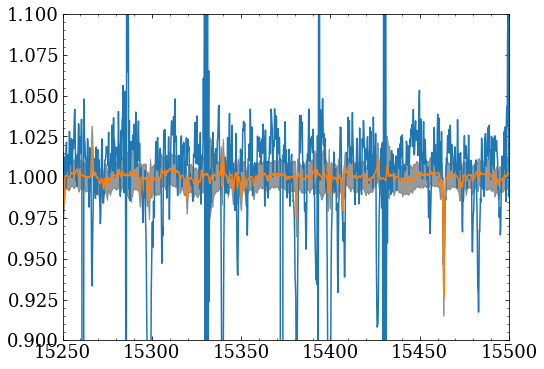

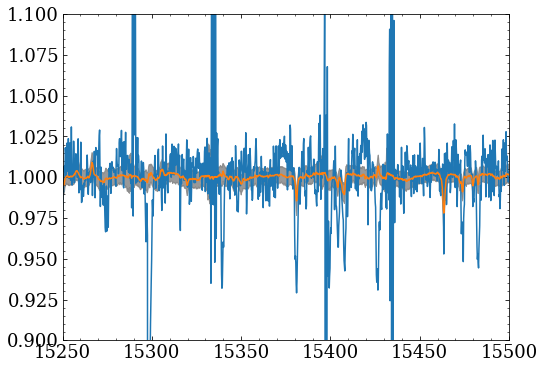

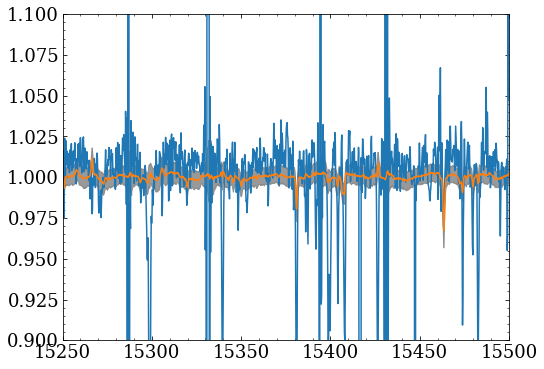

In [6]:
def getspecpath(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

for i in np.random.choice(len(CA_clean), size = 10):
    star = CA_clean[i]
    resdata = get_residual(star['TEFF'], star['LOGG'], star['M_H'])
    res = resdata.data[0,:]
    res_stdv = resdata.data[2,:]
    res_perc16 = resdata.data[4,:]
    res_perc84 = resdata.data[5,:]
    hdul = fits.open(getspecpath(star))
    wavs = getwavs(hdul)
    spec = hdul[1].data

    fig = plt.figure(figsize = (8,6))
    ax = plt.subplot()
    ax.plot(wavs, spec)
    ax.plot(wavs, res)
    ax.fill_between(wavs, res_perc84, res_perc16, color = 'grey', alpha = 0.8)
    ax.plot()

    ax.set_xlim(15250, 15500)
    ax.set_ylim(0.9, 1.1)

    plt.show()

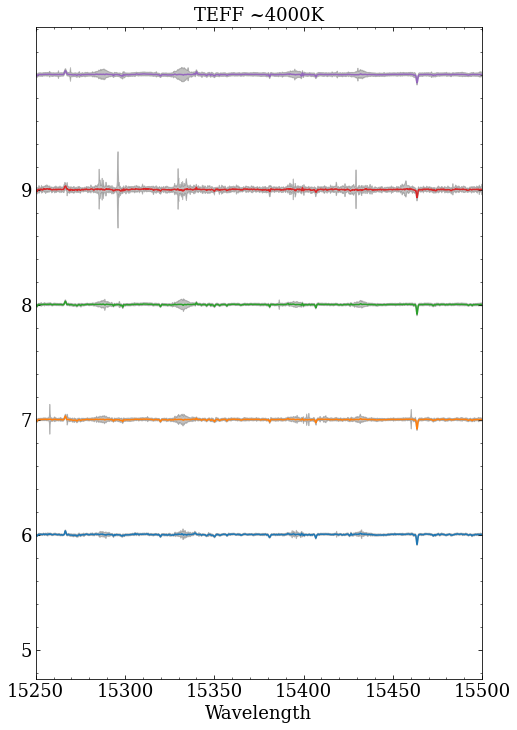

In [7]:
def thing():
    return

teff = 5000
logg = np.arange(0,5,0.5)

fig = plt.figure(figsize = (8, 12))
ax = plt.subplot()

tick = []
ticklabel = []
for i in range(len(logg)):
    residual = get_residual(teff, logg[i], -.2)
    if residual.data is not None:
        ax.plot(wavs, residual.data[0,:] + i)
        tick.append(i)
        ticklabel.append(logg[i])
        ax.fill_between(wavs, residual.data[0,:] + i + residual.data[2,:], 
                        residual.data[0,:]+i-residual.data[2,:], color = 'grey', alpha = 0.5)
ax.set_xlim(15250, 15500)
# ax.set_ylim(0.8, 1.2)

ax.set_title('TEFF ~4000K')
ax.set_xlabel('Wavelength')
ax.set_yticks(tick)
plt.show()

In [8]:
x= fits.open('ResidualsFiles/Residuals_TeffBin3400_3450.fits')[1:]
for item in x:
    dat = item.data
    if dat is not None:
        print(dat[6,:][500])

2.0
3.0
7.0
5.0
5.0
1.0
5.0
3.0
5.0
8.0
8.0
3.0
1.0
1.0
2.0
1.0
5.0
2.0
7.0
3.0
0.0
0.0
1.0
1.0
1.0
2.0
6.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [9]:
meta_5 =meta[np.where(meta['nstars']>5)]

## Deviation per bin

In [10]:
meta_5 =meta[np.where(meta['nstars']>5)]
# m_h_val = -1
# meta_5 = meta_5[np.where((m_h_val > meta_5['m_h_low']) & (m_h_val < meta_5['m_h_high']))[0]]

teff = meta_5['teff_low'] + 0.5 * (meta_5['teff_high'] - meta_5['teff_low'])
logg = meta_5['logg_low'] + 0.5 * (meta_5['logg_high'] - meta_5['logg_low'])
# m_h = meta_5['m_h_low'] + 0.5 * (meta_5['m_h_high'] - meta_5['m_h_low'])
stdv = meta_5['res_std_median']

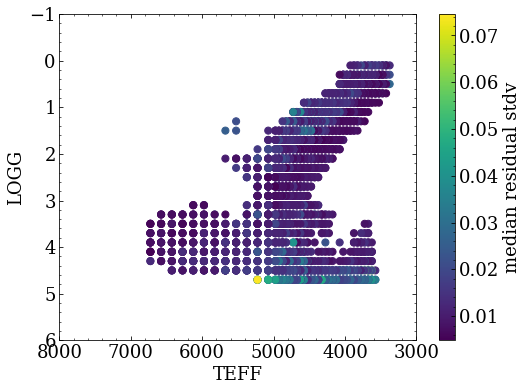

In [11]:
fig = plt.figure(figsize = (8,6))
ax = plt.subplot()
points = ax.scatter(teff, logg, c=stdv, s = 50)
fig.colorbar(points, ax = ax, label = 'median residual stdv')
ax.set_xlim(8000, 3000)
ax.set_ylim(6,-1)
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')
plt.show()

In [12]:
# do a .reshape to get all to the correct shapes, and then imshow entire slices?!? might be a little tricky
# save off all residuals/spectra as pdfs so that they're all in one place


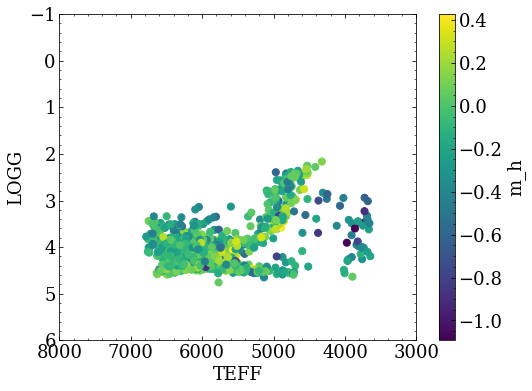

In [13]:
fig = plt.figure(figsize = (8,6))
ax = plt.subplot()
points = ax.scatter(CA_clean['TEFF'], CA_clean['LOGG'], c=CA_clean['M_H'], s = 50)
fig.colorbar(points, ax = ax, label = 'm_h')
ax.set_xlim(8000, 3000)
ax.set_ylim(6,-1)
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')
plt.show()
plt.close()

In [14]:
# CA_residuals = get_residuals_from_tab(CA_clean)

In [15]:
# CA_clean

In [16]:
def make_figure():
    fig = plt.figure(figsize = (8,6))
    ax = plt.subplot()
    
    return fig

In [17]:
stdev = np.array(meta['res_std_median']).reshape(-1, 30, 12)
stdev_ = stdev[:,:,6]
print(stdev_.shape)
print(stdev_.reshape(-1).shape)

stdev_1 = stdev_[:41, :]
stdev_2 = stdev_[41:, :]


(74, 30)
(2220,)


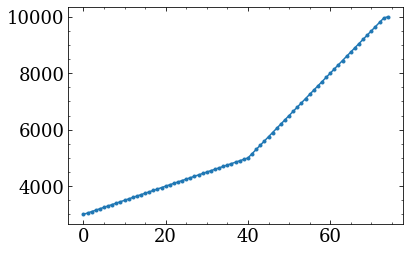

In [18]:
teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.around(np.arange(-1, 5.2, 0.2), 2)
m_h_bins = np.around(np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]]), 2)
plt.plot(teff_bins, marker = '.')
plt.show()

In [19]:
print(len(np.arange(3000, 5000, 50)))

40


In [20]:
print(teff_bins[39])
print(teff_bins[40])
print(teff_bins[41])
# the knee is at 40-41



4950
5000
5150


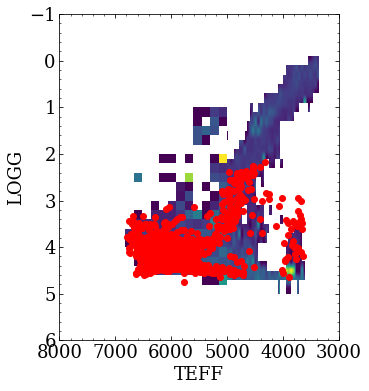

In [21]:
teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.around(np.arange(-1, 5.2, 0.2), 2)
m_h_bins = np.around(np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]]), 2)

extent1 = (teff_bins[40], np.min(teff_bins), np.max(logg_bins), np.min(logg_bins))
extent2 = (np.max(teff_bins), teff_bins[40], np.max(logg_bins), np.min(logg_bins))
aspect1 = np.abs(extent1[1] - extent1[0])/np.abs(extent1[3]-extent1[2])
aspect2 = np.abs(extent2[1] - extent2[0])/np.abs(extent2[3]-extent2[2])
fig, ax = plt.subplots(1,figsize = (8,6))
ax.imshow(stdev_1.T[:, -1::-1], extent = extent1, aspect = aspect1)
ax.imshow(stdev_2.T[:,-1::-1], extent = extent2, aspect = aspect2)

points = ax.scatter(CA_clean['TEFF'], CA_clean['LOGG'], c='r')
# fig.colorbar(points, ax = ax, label = 'm_h')
ax.set_xlim(8000, 3000)
ax.set_ylim(6,-1)
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')
plt.show()

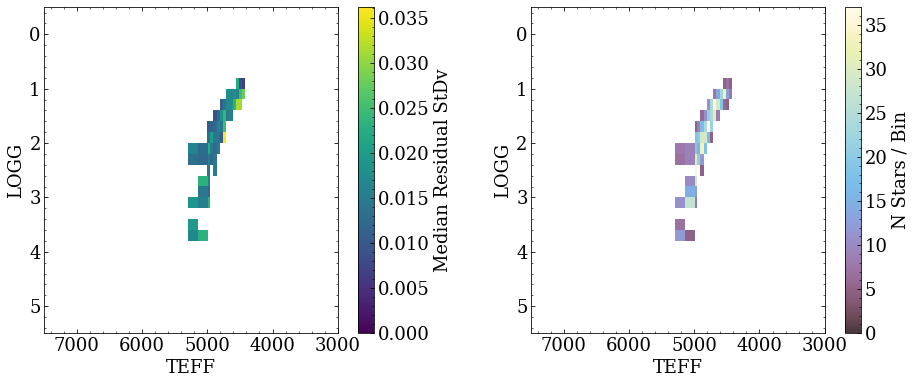

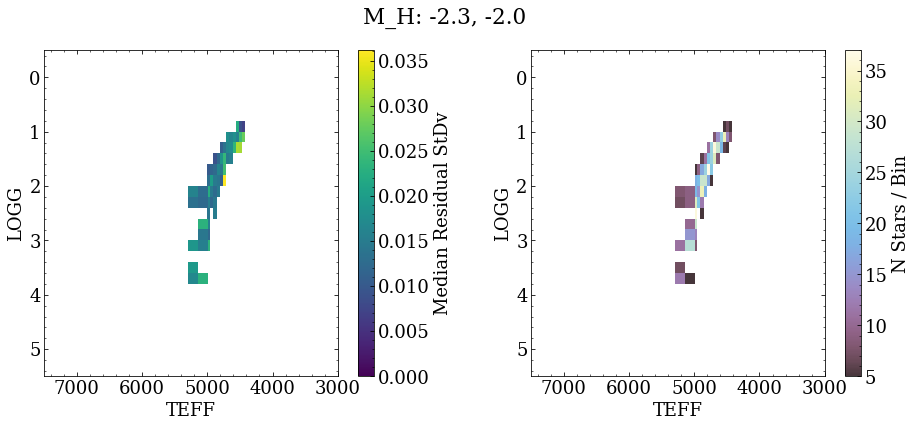

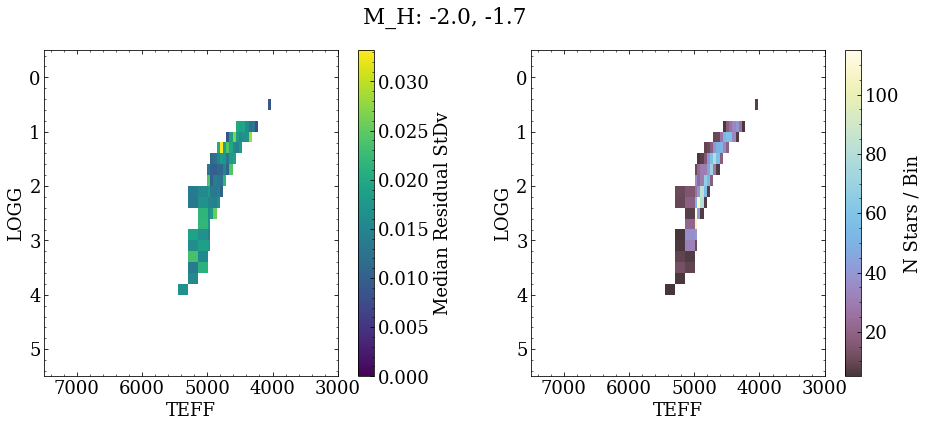

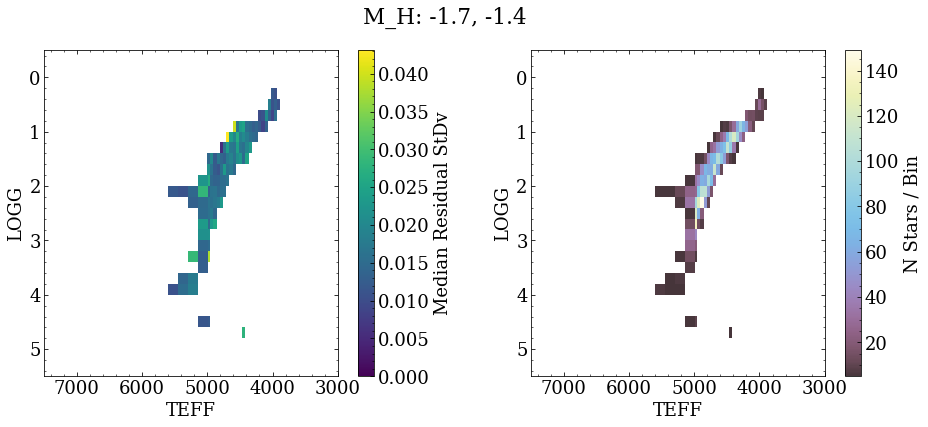

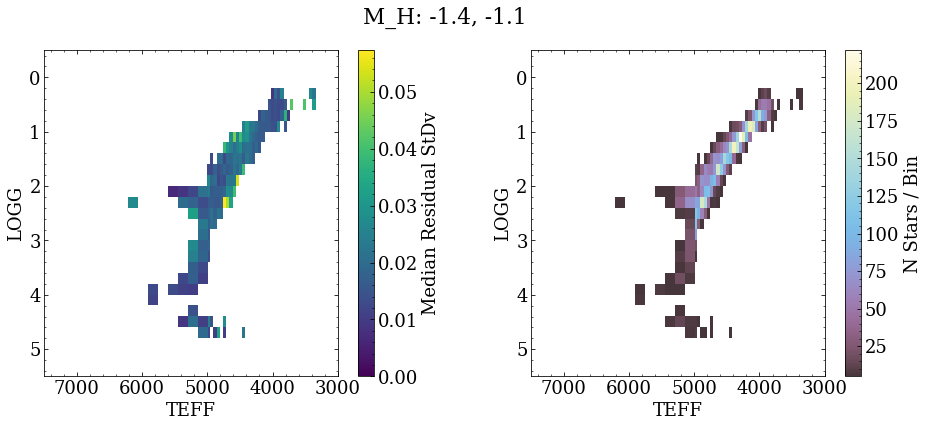

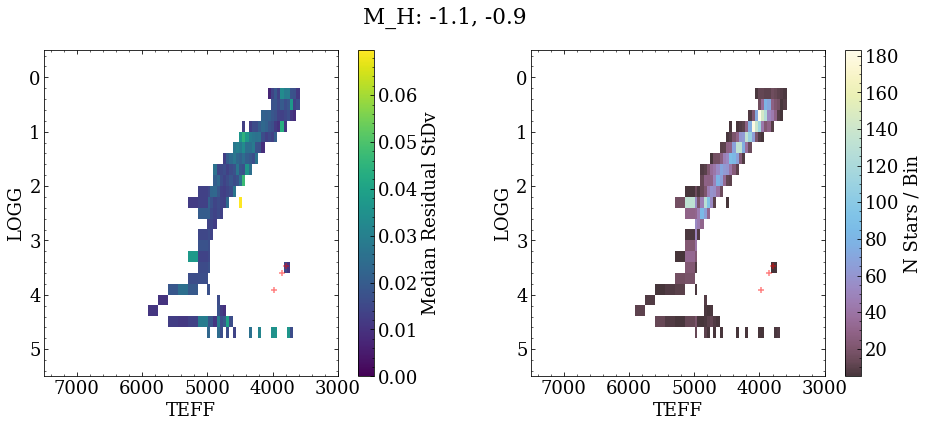

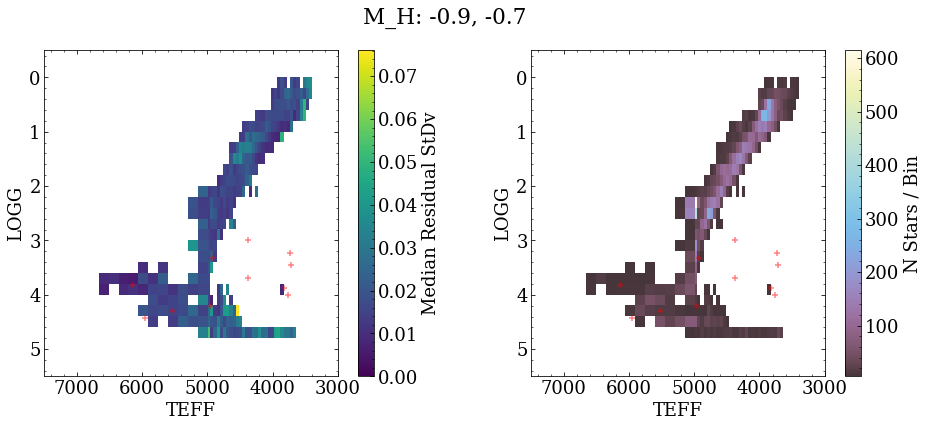

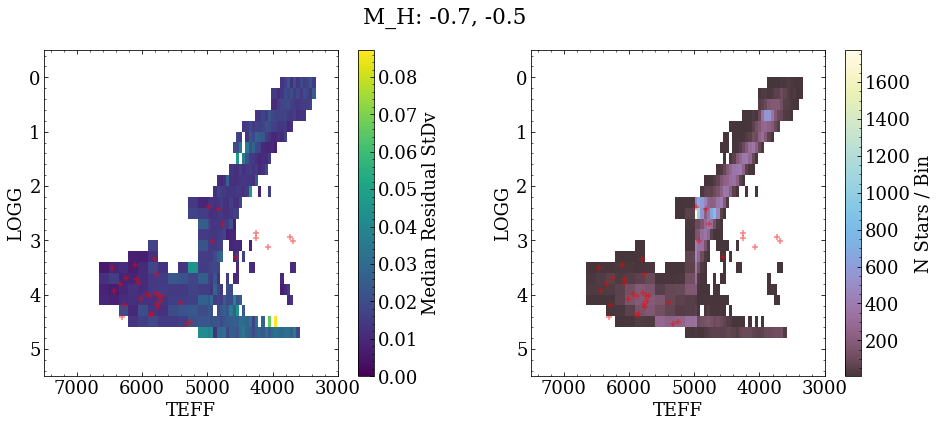

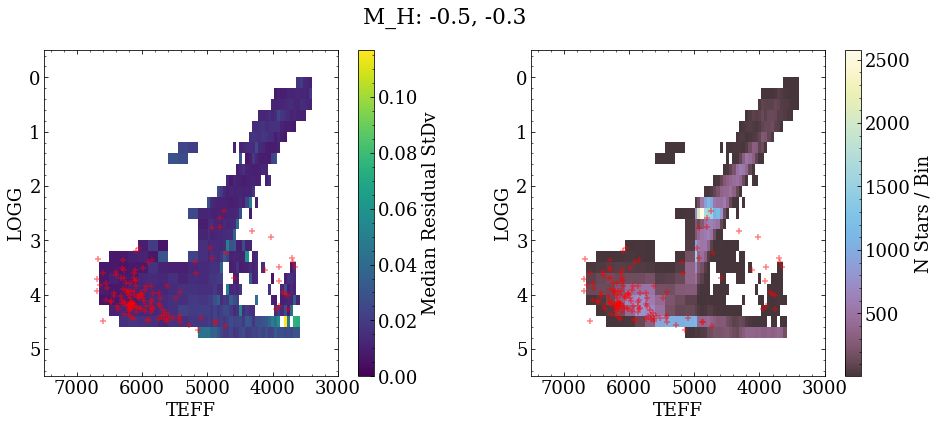

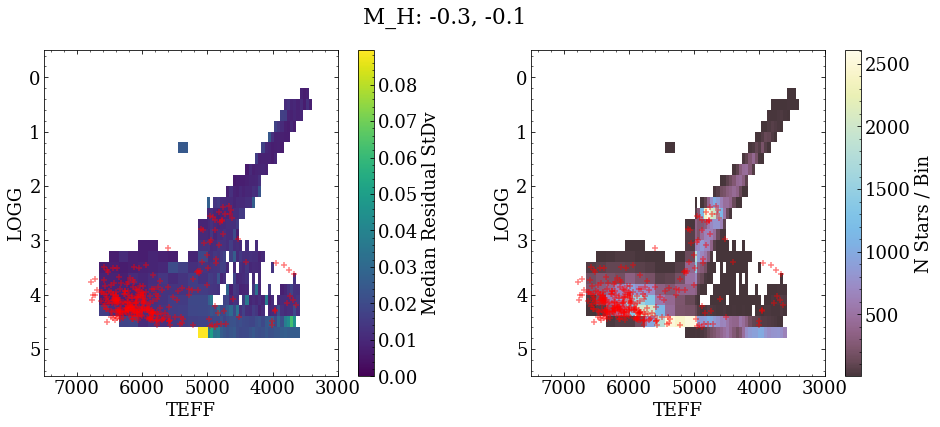

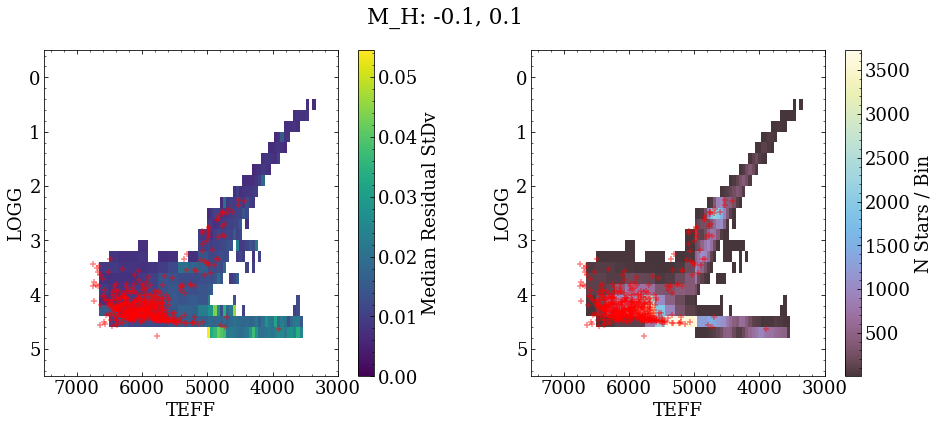

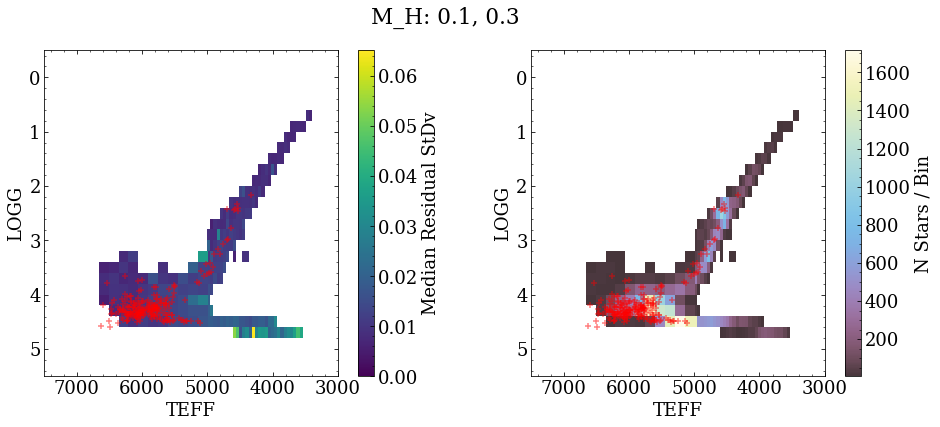

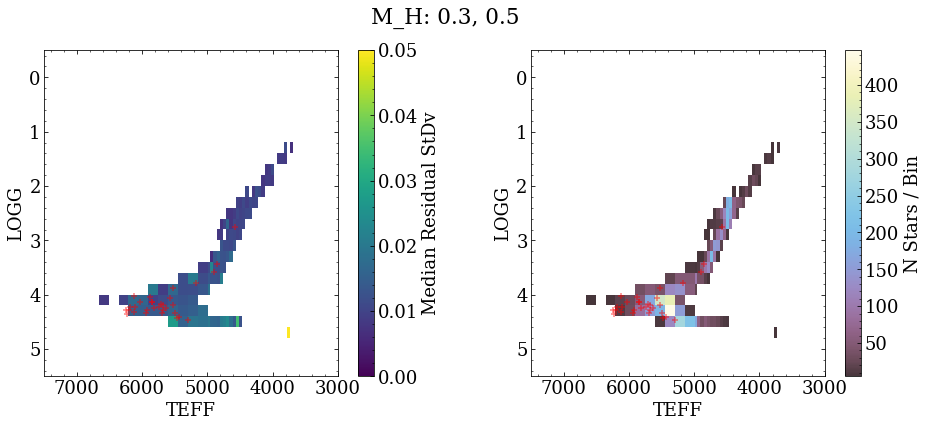

In [25]:
# from matplotlib.backends.backend_pgf import PdfPages
import matplotlib.cm as cm

teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.around(np.arange(-1, 5.2, 0.2), 2)
m_h_bins = np.around(np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]]), 2)

extent1 = (teff_bins[40], np.min(teff_bins), np.max(logg_bins), np.min(logg_bins))
extent2 = (np.max(teff_bins), teff_bins[40], np.max(logg_bins), np.min(logg_bins))
aspect1 = np.abs(extent1[1] - extent1[0])/np.abs(extent1[3]-extent1[2])
aspect2 = np.abs(extent2[1] - extent2[0])/np.abs(extent2[3]-extent2[2])

def hrImage(image, ax, labels = ('aux', 'bin', None), fig = fig, minimum = 0):
    aux, binn, cmap = labels
    image1 = image[:41, :]
    image2 = image[41:, :]
    

    norm = colors.Normalize(minimum, np.nanmax(image))
    
    ax.imshow(image1.T[:, -1::-1], extent = extent1, aspect = aspect1, norm = norm, cmap = cmap)
    ax.imshow(image2.T[:,-1::-1], extent = extent2, aspect = aspect2, norm = norm, cmap = cmap)

    fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), ax = ax, label = aux)
    ax.set_xlim(7500, 3000)
    ax.set_ylim(5.5,-0.5)
    ax.set_xlabel('TEFF')
    ax.set_ylabel('LOGG')


stdev = np.array(meta['res_std_mean']).reshape(-1, 30, 12)
nstar = np.array(meta['nstars']).reshape(-1, 30, 12).astype(float)
# nstar[nstar == 0] = np.nan
minstars = 5
stdev[nstar < minstars] = np.nan
nstar[nstar < minstars] = np.nan


for i in range(len(m_h_bins)-1):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
    
    stdev_slice = stdev[:, :, i]
    nstar_slice = nstar[:, :, i]
    hrImage(stdev_slice, axs[0], labels = ('Median Residual StDv', '', 'viridis'))
    hrImage(nstar_slice, axs[1], labels = ('N Stars / Bin', '', iridescent.reversed()), minimum = minstars)
    
    m_h_low, m_h_high = (m_h_bins[i], m_h_bins[i+1])
    
               
    stars = CA_clean[(CA_clean['M_H'] > m_h_low) & (CA_clean['M_H'] < m_h_high)]
    axs[0].scatter(stars['TEFF'], stars['LOGG'], label = 'CA Stars', marker = '+', c = 'r', alpha = 0.5)
    axs[1].scatter(stars['TEFF'], stars['LOGG'], label = 'CA Stars', marker = '+', c = 'r', alpha = 0.5)
    plt.suptitle('M_H: ' + str(m_h_low) + ', ' + str(m_h_high))


    
    plt.show()
    plt.close()

In [ ]:
# with PdfPages('testpdf.pdf') as pdf:
#     plt.rcParams['text.usetex'] = False

In [26]:
def plotResidualsBin(teff = None, logg = None, m_h = None, plot = (None, None)):
    sum_none = sum(x is not None for x in [teff, logg, m_h])
    if sum_none is not 2: 
        print('Wrong number of specified bins')
        return
    
    if None in plot:
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,8))
    
    bin1, bin2 = tuple(np.array([teff, logg, m_h])[np.array([teff, logg, m_h]) != None])
    binName1, binName2 = tuple(np.array(['TEFF', 'LOGG', 'M_H'])[np.array([teff, logg, m_h]) != None])
    
    

In [27]:
x = (None,1)
None in x

True

Wrong number of rows


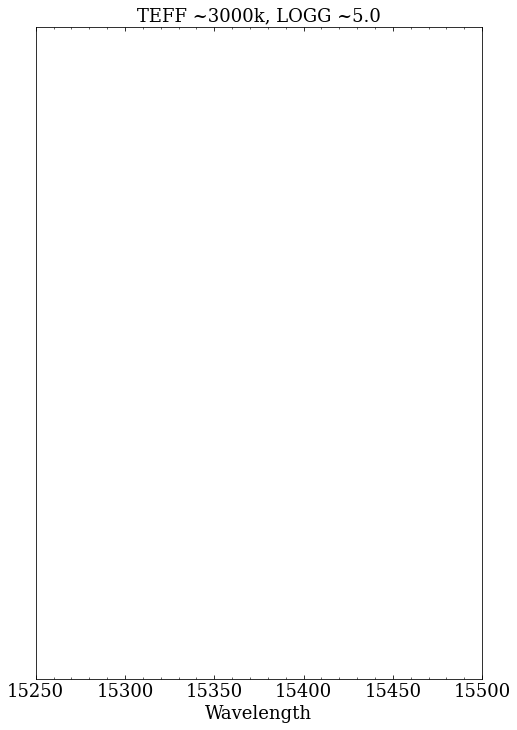

Wrong number of rows


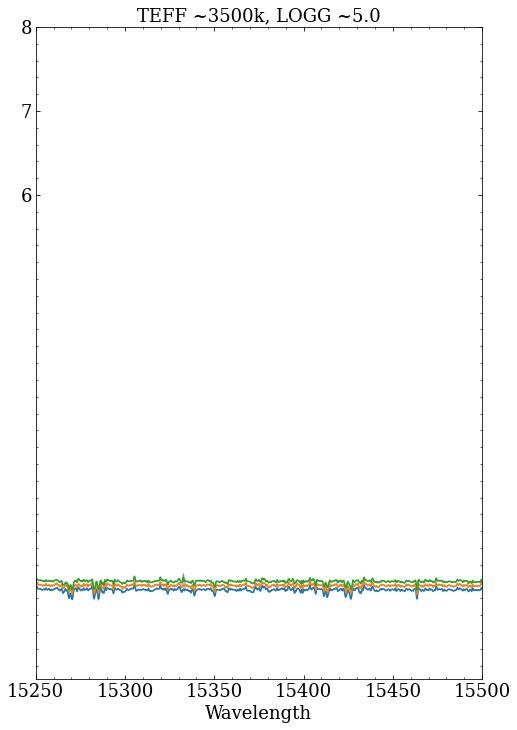

Wrong number of rows


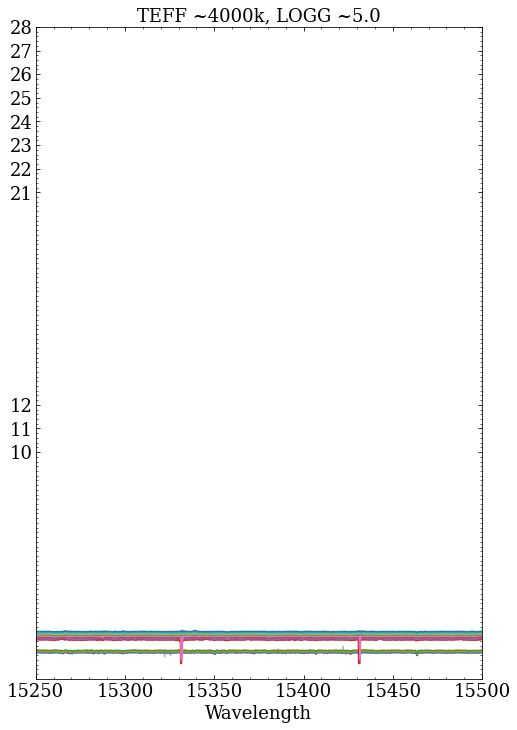

Wrong number of rows


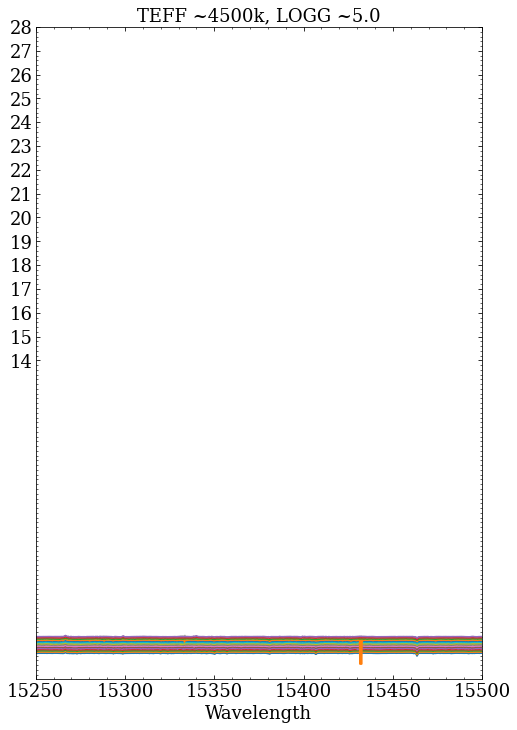

Wrong number of rows


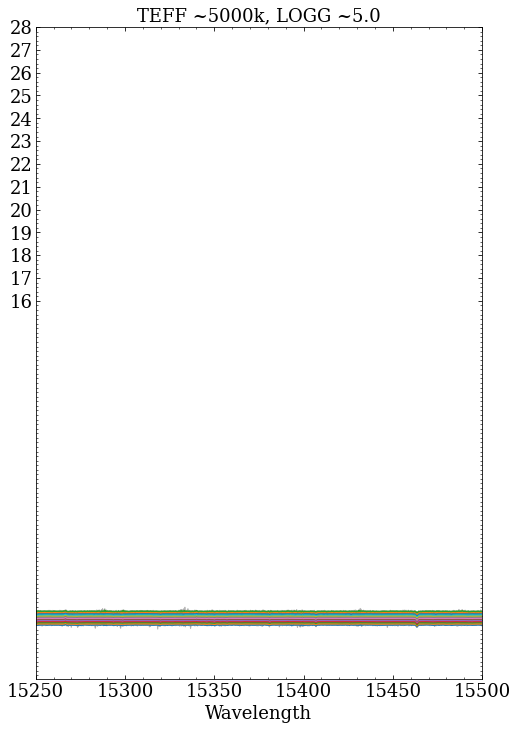

Wrong number of rows


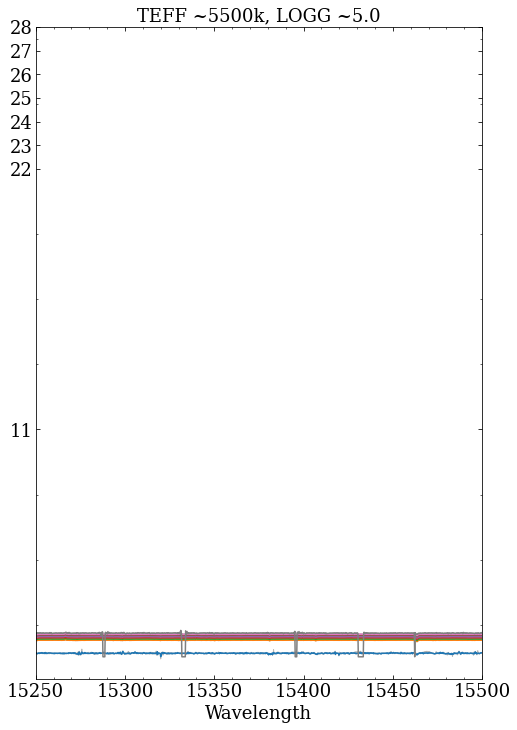

Wrong number of rows


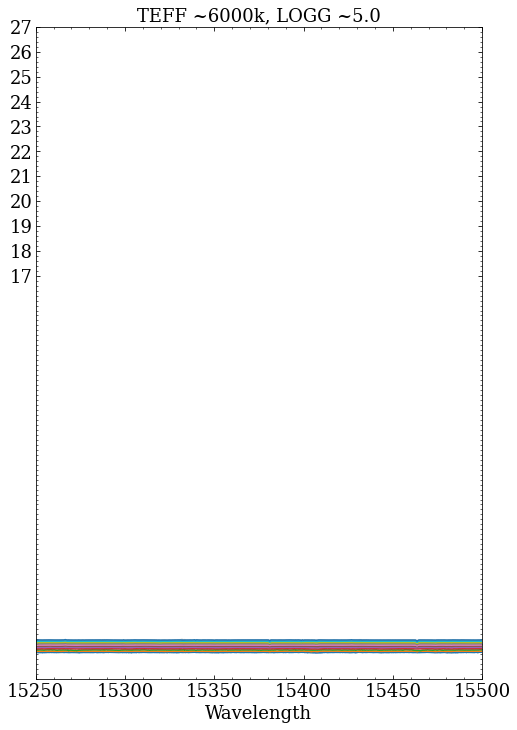

Wrong number of rows


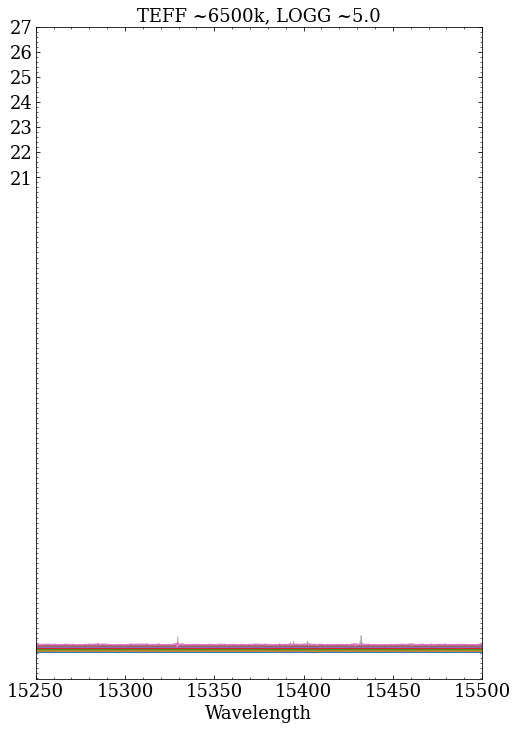

In [31]:
for teff in np.arange(3000, 7000, 500):
# teff = 5000
    logg = logg_bins

    fig = plt.figure(figsize = (8, 12))
    ax = plt.subplot()

    tick = []
    ticklabel = []
    for i in range(len(logg)):
        residual = get_residual(teff, logg[i], -.2)
        if residual is not None:
            if residual.header['NBIN'] > 1:
                ax.plot(wavs,  residual.data[0,:] + 0.05* i)
                tick.append(i)
                ticklabel.append(logg[i])
                ax.fill_between(wavs, i * 0.05 +  residual.data[5,:], 
                                i * 0.05 +   residual.data[4,:], color = 'grey', alpha = 0.5)
    ax.set_xlim(15250, 15500)
    # ax.set_ylim(0.8, 1.2)

    ax.set_title('TEFF ~{t}k, LOGG ~{g}'.format(t=str(teff), g = str(logg[i])))
    ax.set_xlabel('Wavelength')
    ax.set_yticks(tick)
    plt.show()

In [ ]:
# remove bad stuff from the stellar spectra/residuals
# make some summary summary plots
# start correcing stellar spectra to the medianed residuals